In [1]:
%load_ext autoreload
%autoreload 2

import pickle as pkl
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.insert(1, './awp/utils/')

from DataLoader import *
from training import *
from capacity import *

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
def compute_ambiguity(filepath, filename, epsilon):
    data = np.load(filepath+filename+'.npz', allow_pickle=True)
    loss = data['test_loss']
    scores = data['test_likelihood']
    nrepeat = data['nrepeat']
    nmodel = data['nmodel']
    y = data['y_test_all']
    
    n = scores.shape[2]
    
    ambiguity = np.zeros((nrepeat, len(epsilon)))
    
    for i in range(nrepeat):
        m = loss[i, :].min()
        for j in range(len(epsilon)):
            idx = (loss[i, :] < m + epsilon[j])
            score_eps = scores[i, idx, :, :]
            diff = 0
            for k in range(n):
                for l in range(score_eps.shape[0]):
                    if score_eps[l, k, :].argmax() != y[i, k]:
                        diff += 1
                        break
            ambiguity[i, j] = diff/n
    
    return ambiguity       

In [3]:
def compute_discrepancy(filepath, filename, epsilon):
    data = np.load(filepath+filename+'.npz', allow_pickle=True)
    loss = data['test_loss']
    scores = data['test_likelihood']
    nrepeat = data['nrepeat']
    nmodel = data['nmodel']
    y = data['y_test_all']
    
    n = scores.shape[2]
    
    discrepancy = np.zeros((nrepeat, len(epsilon)))
    for i in range(nrepeat):
        m = loss[i, :].min()
        for j in range(len(epsilon)):
            idx = (loss[i, :] < m + epsilon[j])
            score_eps = scores[i, idx, :, :]
            m = score_eps.shape[0]
            
            disc = np.zeros((m,))
            for k in range(m):
                disc[k] = (score_eps[k, :, :].argmax(axis=1) != y[i, :]).sum()/n
                
            discrepancy[i, j] = disc.max()
                
    return discrepancy

In [28]:
epsilon = np.array([0.01, 0.02, 0.05, 0.1])

In [29]:
filepath = '../pred-multi-sample-all/results/'
filename = 'adult-5-sample-all-32512'

adult_amb = compute_ambiguity(filepath, filename, epsilon)
adult_dis = compute_discrepancy(filepath, filename, epsilon)

In [30]:
filepath = '../pred-multi-sample-all/results/'
filename = 'compas-5-sample-all-3694'

compas_amb = compute_ambiguity(filepath, filename, epsilon)
compas_dis = compute_discrepancy(filepath, filename, epsilon)

In [44]:
filepath = '../pred-multi-sample-all/results/'
filename = 'hsls-5-sample-all-10155'

hsls_amb = compute_ambiguity(filepath, filename, epsilon)
hsls_dis = compute_discrepancy(filepath, filename, epsilon)

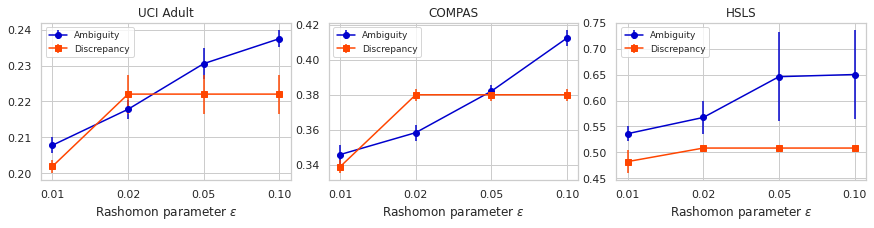

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
colors = ['mediumblue', 'orangered']

epsilon = np.array([0.01, 0.02, 0.05, 0.1])
x = np.arange(len(epsilon))

## Adult
ax[0].errorbar(x, adult_amb.mean(0), yerr=adult_amb.std(0)/np.sqrt(5), marker='o', 
               color=colors[0], label='Ambiguity')
ax[0].errorbar(x, adult_dis.mean(0), yerr=adult_dis.std(0)/np.sqrt(5), marker='s', 
               color=colors[1], label='Discrepancy')

ax[0].set_xticks(np.arange(len(epsilon)))
ax[0].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[0].set_xlabel(r'Rashomon parameter $\epsilon$')

ax[0].legend(ncol=1, loc='upper left', fontsize=9)
ax[0].set_title('UCI Adult')

## COMPAS
ax[1].errorbar(x, compas_amb.mean(0), yerr=compas_amb.std(0)/np.sqrt(5), marker='o', 
               color=colors[0], label='Ambiguity')
ax[1].errorbar(x, compas_dis.mean(0), yerr=compas_dis.std(0)/np.sqrt(5), marker='s', 
               color=colors[1], label='Discrepancy')

ax[1].set_xticks(np.arange(len(epsilon)))
ax[1].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[1].set_xlabel(r'Rashomon parameter $\epsilon$')

ax[1].legend(ncol=1, loc='upper left', fontsize=9)
ax[1].set_title('COMPAS')

## HSLS
ax[2].errorbar(x, hsls_amb.mean(0), yerr=hsls_amb.std(0)/np.sqrt(5), marker='o', 
               color=colors[0], label='Ambiguity')
ax[2].errorbar(x, hsls_dis.mean(0), yerr=hsls_dis.std(0)/np.sqrt(5), marker='s', 
               color=colors[1], label='Discrepancy')

ax[2].set_xticks(np.arange(len(epsilon)))
ax[2].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[2].set_xlabel(r'Rashomon parameter $\epsilon$')
ax[2].legend(ncol=1, loc='upper left', fontsize=9)
ax[2].set_title('HSLS')

plt.tight_layout(pad=0.1)
plt.savefig('adult-compas-hsls-amb-dis.png', format='png', dpi=300)